In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from ngsolve import *
from netgen.geom2d import unit_square


import numpy as np
import scipy
import math
import time

from reduced_basis import *

np.random.seed(42)

<h3> A greedy way to choose snapshot parameters </h3>


We look at a similar example as before. 

From analysis of the equation we know that the density of the eigenvalues increases with higher values of $\omega$. Our sample rate however does not change because we choose equidistant snapsots. Also the residual at the beginning is not good.

In [2]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.2))

fes = H1(mesh, order=3, dirichlet="bottom|right")
u,v = fes.TnT()
blf = [grad(u)*grad(v)*dx, None, -u*v *dx]

rhs = 100*exp(-20*((x-0.6)**2 + (y-0.3)**2))*v*dx

snapshots = np.arange(0,25, 5)
space1 = ReducedBasis(fes, blf, rhs, snapshots)

random_omegas = np.sort(np.append(np.random.uniform(space1.omega_min, space1.omega_max, 1000), snapshots))

slider_func1 = lambda x: space1.draw(x, redraw=True)
space1.draw(space1.omega_min)

interact(slider_func1, x=widgets.FloatSlider(min=space1.omega_min, max=space1.omega_max, step=0.05, value=space1.omega_min))

compute Reduced Basis for snapshots  [ 0  5 10 15 20]
finished computing Reduced Basis
omega: 0, norm of solution: 3.221872670246274


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2007-1-g90581404c', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, …

interactive(children=(FloatSlider(value=0.0, description='x', max=20.0, step=0.05), Output()), _dom_classes=('…

<function __main__.<lambda>(x)>

compute residual and norm
finished computing values


<IPython.core.display.Javascript object>


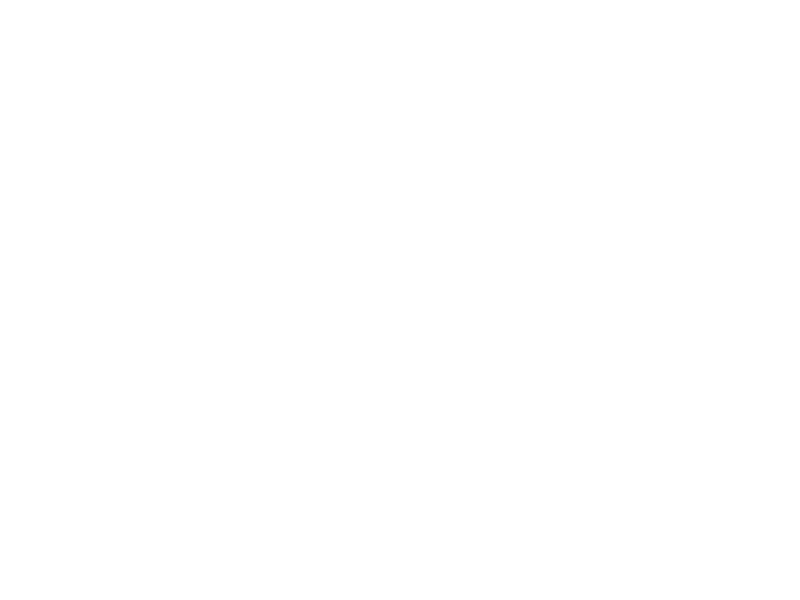

<IPython.core.display.Javascript object>


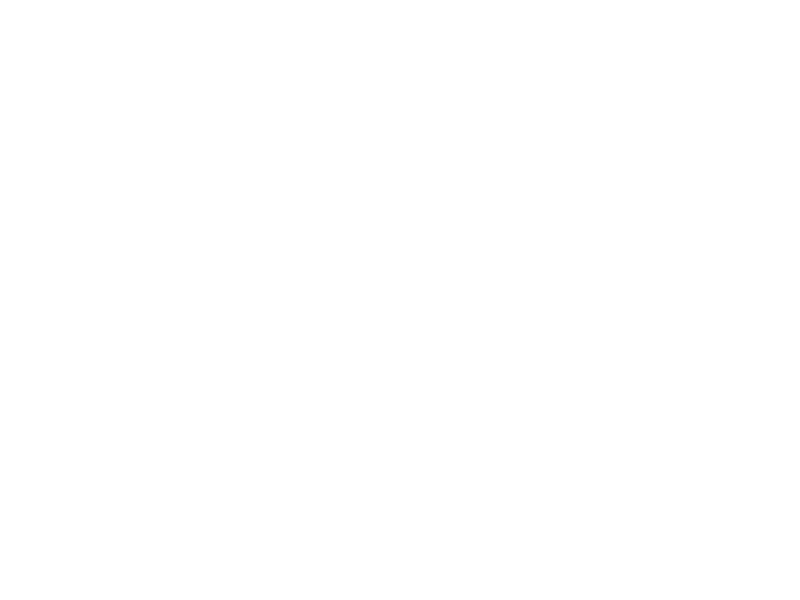

compute residual
finished computing values
 maximal residual: 112294801.0258727 
 amount of snapshots: 5


In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt

space1.logging  = True
norm_random_omegas, residual_random_omegas = space1.computeValues(random_omegas)


fig, ax = plt.subplots()
ax.plot(random_omegas, norm_random_omegas,  '-', label = "norm")
ax.set_xlabel("omega")
ax.set_ylabel("norm of solution")
ax.set_title("norm of solution in reduced space")
plt.semilogy()

fig, ax = plt.subplots()         
ax.plot(random_omegas, residual_random_omegas , '-')
residual = space1.computeValues(space1.getSnapshots(), norm = False)
ax.plot(space1.getSnapshots(), residual, 'r.', label = "snapshot parameters")
ax.legend()
ax.set_xlabel("omega")
ax.set_ylabel('residual of solution')
ax.set_title("residual in reduced space")
plt.semilogy()

print(" maximal residual: {} \n amount of snapshots: {}".format(max(residual_random_omegas), len(space1.getSnapshots())))

One way to tackle this issue is to choose the snapshots dynamically. Therefore we can start with a small set of snapshot parameters and extend this set with the value where the residual is the highest.

To see what is going on, we plot the residual for each new snapshot.
If we run the same code with `CHEAP = True` and `CHEAP = False` we can observe that the cheap residual brings a considerable improvement in computation time.

<IPython.core.display.Javascript object>


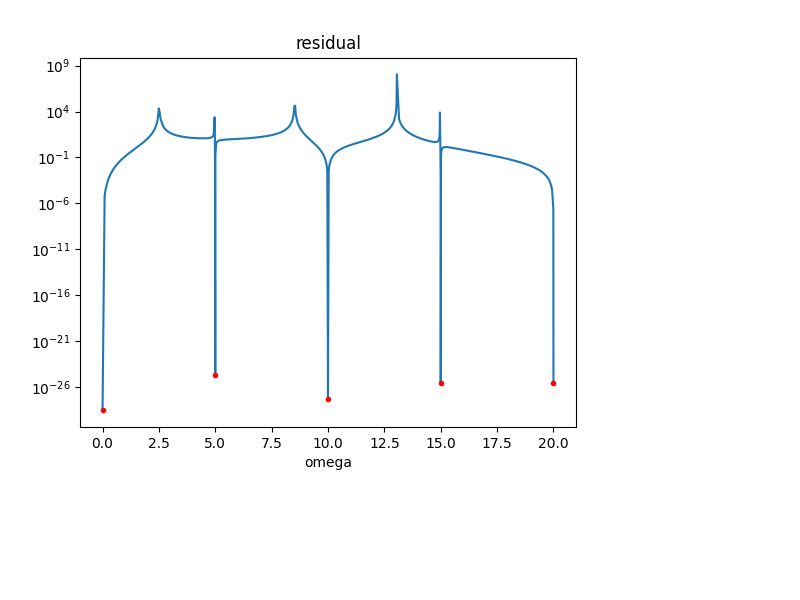

compute Reduced Basis for snapshots  [ 0  5 10 15 20]
finished computing Reduced Basis


TypeError: 'numpy.float64' object is not iterable

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt

MAX_IT = 100
CHEAP = False 
THRESHOLD = 1e-5

# initialize plot
fig_r = plt.figure()
ax_r = fig_r.add_subplot(111)
plt.ion()
fig_r.show()
fig_r.canvas.draw()
space = ReducedBasis(fes, blf, rhs, snapshots)
space.logging = False

begin_time = time.time()

for i in range(MAX_IT):
    
    residual = space.computeValues(random_omegas, norm=False, cheap = CHEAP)
    
    ax_r.clear()    
    ax_r.plot(random_omegas, residual , '-')
    sn_residual = space.computeValues(space.getSnapshots(), norm = False, cheap = CHEAP)
    ax_r.plot(space.getSnapshots(), sn_residual, 'r.', label = 'snapshots')
    ax_r.set_xlabel('omega')
    ax_r.set_title('residual')
    plt.semilogy()
    
    if (max(residual) < THRESHOLD): 
        print("Finished after {} seconds".format(time.time()-begin_time))
        break
    
    # sort by residual (descending)
    zip_to_sort = list(zip(residual, range(len(residual))))
    sorted_zip = sorted(zip_to_sort, key=lambda x: x[0], reverse=True)
    index = [tup[1] for tup in sorted_zip]
    
    for i in index:
        if not random_omegas[i] in space.getSnapshots(): 
            space.addSnapshots([random_omegas[i]])
            break
    
    print("add snapshot for omega = {} maximal residual: {}".format(random_omegas[i], max(residual)))

    
    ax_r.plot(random_omegas[i], residual[i], 'g*', label = 'snapshot to add')
    ax_r.legend()

    fig_r.canvas.draw()
    


print(" maximal residual: {} \n amount of snapshots: {}".format(max(residual), len(space.getSnapshots())))




Again we can calculate and plot the solutions in the new reduced space and see that the visual impression gets better.  

In [ ]:
slider_func = lambda x: space.draw(x, redraw=True)
space.draw(space.omega_min)
interact(slider_func, x=widgets.FloatSlider(min=space.omega_min, max=space.omega_max, step=0.05, value=space.omega_min))

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt

space.logging  = True
norm_random_omegas, residual_random_omegas = space.computeValues(random_omegas)

fig, ax = plt.subplots()
ax.plot(random_omegas, norm_random_omegas,  '-', label = "norm")
ax.set_xlabel("omega")
ax.set_ylabel("norm of solution")
ax.set_title("norm of solution in reduced space")
plt.semilogy()

fig, ax = plt.subplots()         
ax.plot(random_omegas, residual_random_omegas , '-')
residual = space.computeValues(space.getSnapshots(), norm = False)
ax.plot(space.getSnapshots(), residual, 'r.', label = "snapshot parameters")
ax.legend()
ax.set_xlabel("omega")
ax.set_ylabel('residual of solution')
ax.set_title("residual in reduced space")
plt.semilogy()